# Fe K $\alpha$ emission from SN1006

All imports

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from CRp_gamma import Phi_pp_gamma, velocity 
# Takes CRp spectrum in MeV-1 cm-3 and returns gamma spectrum in erg cm-3 s-1
from CRe_gamma_radio import Phi_e_syn, Phi_e_rel_brem, Phi_e_IC
# Takes CRe spectrum in MeV-1 cm-3 and returns gamma spectrum in erg cm-3 s-1
from FeKalpha_CR import Phi_Fe_64_p, Phi_Fe_64_e
# Takes CR spectrum in MeV-1 cm-3 and returns flux in photons cm-2 s-1
from IPython.display import display, Latex

## Parameters

General constants 

In [2]:
MeV_to_erg = 1.602e-6 
m_p = 938.272 #MeV
m_e = 0.511  #MeV
c = 3e10 #cm/s
hPlanck = 4.135e-21 #MeV s
M_sol = 2e30 # kg
m_H = 1.67e-27 # kg
m_avg = 1.4*m_H
sigma_sb=35.394474508 #MeV cm^-2 s^-1 K^-4

Cloud and shell parameters

In [3]:
ds = 2.2 * (3e21) #cm

M_cl = 0.4 * M_sol #kg
R_cl = 2 * 3e18 #cm (Miceli et al. 2016)
V_cl = (4 / 3) * np.pi * (R_cl ** 3)
n_cl = 0.5 #cm-3 (Miceli et al. 2016)
#n_cl_2 = 10 #cm-3 (Miceli et al. 2014a)
B_cl = 3e-2 #mG (Miceli et al. 2016)
eta_Fe = 3e-5 
emi_pre_cl = V_cl / (4 * np.pi * (ds ** 2)) # cm

M_sh = 0.5 * M_sol #kg
R_sh = 7.7 * 3e18 #cm (Cristofari et al. 2019)
xf = 0.25 #(Cristofari et al. 2019)
V_sh = (xf / 3) * np.pi * (R_sh ** 3) #cm3 (Cristofari et al. 2019)
n_sh = 0.05 #cm-3 (Acero et al. 2007)
#n_sh = 0.12 #cm-3
B_sh = 1e-2 #mG (Cristofari et al.2019)
#B_sh = 0.1 #mG (Berezhko et al. 2003)
emi_pre_sh = V_sh / (4 * np.pi * (ds ** 2)) # cm

Photon field parameters

In [4]:
# T is K, w in MeV cm-3
T_CMB, w_CMB = 2.72, 0.261e-6
k_CMB = w_CMB * c / (sigma_sb * (T_CMB ** 4))
T_NIR, w_NIR = 30.0, 0.5e-6
k_NIR = w_NIR * c / (sigma_sb * (T_NIR ** 4))
T_FIR, w_FIR = 3000.0, 1.0e-6
k_FIR = w_FIR * c / (sigma_sb * (T_FIR ** 4))

CR spectrum form

In [5]:
def J_CRp(T_p, del_p, Ap, Tp_c):
    # Gives spectrum in MeV-1 cm-3
    v = velocity(T_p, m_p)[0]
    p2 = (T_p ** 2) + (2 * T_p * m_p) # MeV2
    p2_GeV = 1e-6 * p2 #GeV2
    return (4 * np.pi / v) * Ap * np.power(p2_GeV, -del_p / 2) * np.exp(- T_p / Tp_c)

def J_CRe(T_e, del_e, Ae, Te_c):
    # Gives spectrum in MeV-1 cm-3
    v = velocity(T_e, m_e)[0]
    p2 = (T_e ** 2) + (2 * T_e * m_e) #MeV2
    p2_GeV = 1e-6 * p2
    return (4 * np.pi / v) * Ae * np.power(p2_GeV, -del_e / 2) * np.exp(- T_e / Te_c)

## Load multi-wavelength data

Import data

In [6]:
radio_data = np.genfromtxt(open("SN1006_data_radio.txt", "r"), delimiter=',') # in Hz and Jy Hz
xray_data = np.genfromtxt(open("SN1006_data_suzaku.txt", "r"), delimiter=',') # in eV and eV cm-2 s-1
fermi_data = np.genfromtxt(open("SN1006_data_SW_FERMI.txt", "r"), delimiter=',') # in GeV and erg cm-2 s-1
fermi_upper_data = np.genfromtxt(open("SN1006_data_SW_upper_FERMI_Acero2015.txt", "r"), delimiter=',') # in eV and erg cm-2 s-1
hess_data = np.genfromtxt(open("SN1006_data_SW_HESS.txt", "r"), delimiter=',') # in eV and erg cm-2 s-1

Converting all data sets to $\mathrm{MeV}$ and $\mathrm{erg.cm^{-2}.s^{-1}}$

In [7]:
Er, Phi_radio = radio_data[:, 0] * hPlanck, 1e-23 * radio_data[:, 1] 
Ex, Phi_xray = xray_data[:, 0] * 1e-6, xray_data[:, 1] * 1.602e-12
Ef, Efm, Efp, Phi_fermi, Phi_fp, Phi_fm = fermi_data[:, 0] * 1e3, fermi_data[:, 1] * 1e3, fermi_data[:, 2] * 1e3, fermi_data[:, 3], fermi_data[:, 4], fermi_data[:, 5]
Efu, Phi_fermi_up = fermi_upper_data[:, 0] * 1e-6, fermi_upper_data[:, 1]
Eh, Phi_hp, Phi_hm = hess_data[:, 0] * 1e-6, hess_data[:, 1], hess_data[:, 2] 

X-ray fit

In [8]:
def Xray_fit(E):
    return 2.3e-12 * np.power(E * 1e3, -3)

Phi_xray_fit = np.array([Xray_fit(E) for E in np.logspace(-13, 8, 50)])

def Xray_fit_2(E):
    return 6.0 * np.power(E * 1e3, -3) #MeV-1 cm-2 s-1

Phi_xray_fit_2 = np.array([E * E * Xray_fit_2(E) * MeV_to_erg for E in np.logspace(-13, 8, 50)])

Plot data

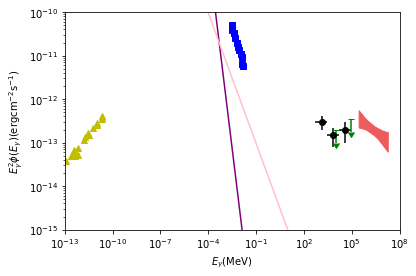

In [9]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(np.logspace(-13, 8, 50), Phi_xray_fit, color='purple')
plt.plot(np.logspace(-13, 8, 50), Phi_xray_fit_2, color='pink')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

## Fit gamma-ray data

In [10]:
E_g_list = np.logspace(-13, 8, 50)

Fit data with $\delta=2.0$

In [11]:
del_p_20, Ap_20, Tp_c_20 = 2.0, 1.7e-1, 1e9
del_e_20, Ae_20, Te_c_20 = 2.0, 1.6e-4, 1e7

Phi_p_gamma_cl_20 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_20, Ap_20, Tp_c_20, n_cl) for E in E_g_list])
Phi_p_gamma_sh_20 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_20, Ap_20, Tp_c_20, n_sh) for E in E_g_list])

Phi_e_IC_cl_20 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_20, Ae_20, Te_c_20, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_20, Ae_20, Te_c_20, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_20, Ae_20, Te_c_20, T_FIR, k_FIR) for E in E_g_list])
Phi_e_IC_sh_20 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_20, Ae_20, Te_c_20, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_20, Ae_20, Te_c_20, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_20, Ae_20, Te_c_20, T_FIR, k_FIR) for E in E_g_list])

Phi_e_brem_cl_20 = emi_pre_cl * np.array([Phi_e_rel_brem(E_g, J_CRe, del_e_20, Ae_20, Te_c_20, n_cl) for E_g in E_g_list])
Phi_e_brem_sh_20 = emi_pre_sh * np.array([Phi_e_rel_brem(E_g, J_CRe, del_e_20, Ae_20, Te_c_20, n_sh) for E_g in E_g_list])

Phi_e_syn_cl_20 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_20, Ae_20, Te_c_20, 10e-3) for E in E_g_list])
Phi_e_syn_sh_20 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_20, Ae_20, Te_c_20, 10e-3) for E in E_g_list])

Phi_p_gamma_20 = Phi_p_gamma_cl_20 + Phi_p_gamma_sh_20
Phi_e_IC_20 = Phi_e_IC_cl_20 + Phi_e_IC_sh_20
Phi_e_brem_20 = Phi_e_brem_cl_20 + Phi_e_brem_sh_20
Phi_e_gamma_20 = Phi_e_IC_20 + Phi_e_brem_20
Phi_e_syn_20 = Phi_e_syn_cl_20 + Phi_e_syn_sh_20
Phi_total_20 = Phi_p_gamma_20 + Phi_e_gamma_20 + Phi_e_syn_20

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


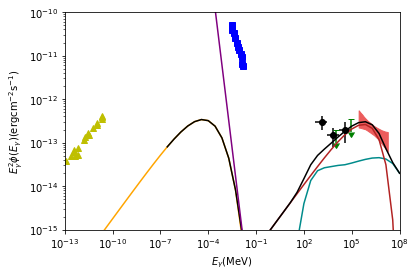

In [12]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(E_g_list, Phi_p_gamma_20, color='darkcyan', label='p')
plt.plot(E_g_list, Phi_e_gamma_20, color='firebrick', label='e')
plt.plot(E_g_list, Phi_e_syn_20, color='orange', label='syn')
plt.plot(E_g_list, Phi_total_20, color='black', label='tot')
plt.plot(E_g_list, Phi_xray_fit, color='purple')
#plt.plot(E_g_list, Phi_xray_fit_2, color='pink')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(MeV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

Fit with $\delta=2.4$

In [13]:
del_p_24, Ap_24, Tp_c_24 = 2.4, 2.8, 1e9
del_e_24, Ae_24, Te_c_24 = 2.4, 3e-3, 3e7

Phi_p_gamma_cl_24 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_24, Ap_24, Tp_c_24, n_cl) for E in E_g_list])
Phi_p_gamma_sh_24 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_24, Ap_24, Tp_c_24, n_sh) for E in E_g_list])

Phi_e_IC_cl_24 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_24, Ae_24, Te_c_24, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_24, Ae_24, Te_c_24, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_24, Ae_24, Te_c_24, T_FIR, k_FIR) for E in E_g_list])
Phi_e_IC_sh_24 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_24, Ae_24, Te_c_24, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_24, Ae_24, Te_c_24, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_24, Ae_24, Te_c_24, T_FIR, k_FIR) for E in E_g_list])

Phi_e_brem_cl_24 = emi_pre_cl * np.array([Phi_e_rel_brem(E_g, J_CRe, del_e_24, Ae_24, Te_c_24, n_cl) for E_g in E_g_list])
Phi_e_brem_sh_24 = emi_pre_sh * np.array([Phi_e_rel_brem(E_g, J_CRe, del_e_24, Ae_24, Te_c_24, n_sh) for E_g in E_g_list])

Phi_e_syn_cl_24 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_24, Ae_24, Te_c_24, 5e-3) for E in E_g_list])
Phi_e_syn_sh_24 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_24, Ae_24, Te_c_24, 5e-3) for E in E_g_list])

Phi_p_gamma_24 = Phi_p_gamma_cl_24 + Phi_p_gamma_sh_24
Phi_e_IC_24 = Phi_e_IC_cl_24 + Phi_e_IC_sh_24
Phi_e_brem_24 = Phi_e_brem_cl_24 + Phi_e_brem_sh_24
Phi_e_gamma_24 = Phi_e_IC_24 + Phi_e_brem_24
Phi_e_syn_24 = Phi_e_syn_cl_24 + Phi_e_syn_sh_24
Phi_total_24 = Phi_p_gamma_24 + Phi_e_gamma_24 + Phi_e_syn_24

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


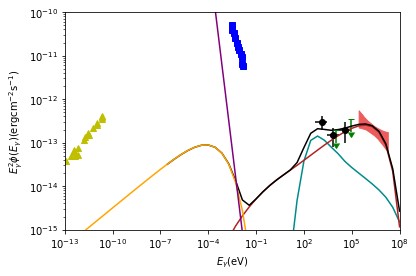

In [14]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(E_g_list, Phi_p_gamma_24, color='darkcyan', label='p')
plt.plot(E_g_list, Phi_e_gamma_24, color='firebrick', label='e')
plt.plot(E_g_list, Phi_total_24, color='black', label='tot')
plt.plot(E_g_list, Phi_e_syn_24, color='orange', label='syn')
plt.plot(E_g_list, Phi_xray_fit, color='purple')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(eV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

Fit with $\delta=2.8$

In [15]:
del_p_28, Ap_28, Tp_c_28 = 2.8, 7.0, 1e9
del_e_28, Ae_28, Te_c_28 = 2.8, 6e-2, 1e8

Phi_p_gamma_cl_28 = emi_pre_cl * np.array([Phi_pp_gamma(E, J_CRp, del_p_28, Ap_28, Tp_c_28, n_cl) for E in E_g_list])
Phi_p_gamma_sh_28 = emi_pre_sh * np.array([Phi_pp_gamma(E, J_CRp, del_p_28, Ap_28, Tp_c_28, n_sh) for E in E_g_list])

Phi_e_IC_cl_28 = emi_pre_cl * np.array([Phi_e_IC(E, J_CRe, del_e_28, Ae_28, Te_c_28, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_28, Ae_28, Te_c_28, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_28, Ae_28, Te_c_28, T_FIR, k_FIR) for E in E_g_list])
Phi_e_IC_sh_28 = emi_pre_sh * np.array([Phi_e_IC(E, J_CRe, del_e_28, Ae_28, Te_c_28, T_CMB, k_CMB) + Phi_e_IC(E, J_CRe, del_e_28, Ae_28, Te_c_28, T_NIR, k_NIR) + Phi_e_IC(E, J_CRe, del_e_28, Ae_28, Te_c_28, T_FIR, k_FIR) for E in E_g_list])

Phi_e_brem_cl_28 = emi_pre_cl * np.array([Phi_e_rel_brem(E_g, J_CRe, del_e_28, Ae_28, Te_c_28, n_cl) for E_g in E_g_list])
Phi_e_brem_sh_28 = emi_pre_sh * np.array([Phi_e_rel_brem(E_g, J_CRe, del_e_28, Ae_28, Te_c_28, n_sh) for E_g in E_g_list])

Phi_e_syn_cl_28 = emi_pre_cl * np.array([Phi_e_syn(E, J_CRe, del_e_28, Ae_28, Te_c_28, 1e-3) for E in E_g_list])
Phi_e_syn_sh_28 = emi_pre_sh * np.array([Phi_e_syn(E, J_CRe, del_e_28, Ae_28, Te_c_28, 1e-3) for E in E_g_list])

Phi_p_gamma_28 = Phi_p_gamma_cl_28 + Phi_p_gamma_sh_28
Phi_e_IC_28 = Phi_e_IC_cl_28 + Phi_e_IC_sh_28
Phi_e_brem_28 = Phi_e_brem_cl_28 + Phi_e_brem_sh_28
Phi_e_gamma_28 = Phi_e_IC_28 + Phi_e_brem_28
Phi_e_syn_28 = Phi_e_syn_cl_28 + Phi_e_syn_sh_28
Phi_total_28 = Phi_p_gamma_28 + Phi_e_gamma_28 + Phi_e_syn_28

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


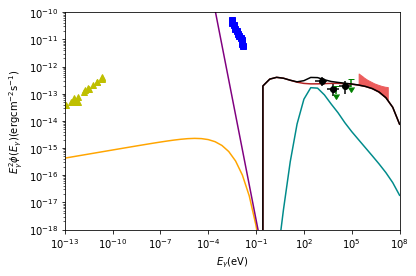

In [16]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(E_g_list, Phi_p_gamma_28, color='darkcyan', label='p')
plt.plot(E_g_list, Phi_e_gamma_28, color='firebrick', label='e')
plt.plot(E_g_list, Phi_e_syn_28, color='orange', label='syn')
plt.plot(E_g_list, Phi_total_28, color='black')
plt.plot(E_g_list, Phi_xray_fit, color='purple')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$E_{\gamma}\mathrm{(eV)}$')
plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm^{-2} s^{-1})}$')
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-18,1.0e-10)
plt.show()

## Fe K $\alpha$ line emission

In [34]:
E_min = 10e-3 #MeV

Fe_64_p_20 = Phi_Fe_64_p(E_min, J_CRp, del_p_20, Ap_20, Tp_c_20, M_cl, eta_Fe) / (4 * np.pi * (ds ** 2))
Fe_64_e_20 = Phi_Fe_64_e(E_min, J_CRe, del_e_20, Ae_20, Te_c_20, M_cl, eta_Fe) / (4 * np.pi * (ds ** 2))

Fe_64_p_24 = Phi_Fe_64_p(E_min, J_CRp, del_p_24, Ap_24, Tp_c_24, M_cl, eta_Fe) / (4 * np.pi * (ds ** 2))
Fe_64_e_24 = Phi_Fe_64_e(E_min, J_CRe, del_e_24, Ae_24, Te_c_24, M_cl, eta_Fe) / (4 * np.pi * (ds ** 2))

Fe_64_p_28 = Phi_Fe_64_p(E_min, J_CRp, del_p_28, Ap_28, Tp_c_28, M_cl, eta_Fe) / (4 * np.pi * (ds ** 2))
Fe_64_e_28 = Phi_Fe_64_e(E_min, J_CRe, del_e_28, Ae_28, Te_c_28, M_cl, eta_Fe) / (4 * np.pi * (ds ** 2))

In [39]:
display(Latex(r'Fe K $\alpha$ photon flux for spectral index 2.0:'))
print(r'from CR protons:', Fe_64_p_20, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_20, 'cm-2 s-1')

display(Latex(r'Fe K $\alpha$ photon flux for spectral index 2.4:'))
print(r'from CR protons:', Fe_64_p_24, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_24, 'cm-2 s-1')

display(Latex(r'Fe K $\alpha$ photon flux for spectral index 2.8:'))
print(r'from CR protons:', Fe_64_p_28, 'cm-2 s-1')
print(r'from CR electrons:', Fe_64_e_28, 'cm-2 s-1')

<IPython.core.display.Latex object>

from CR protons: 1.1040194240974205e-15 cm-2 s-1
from CR electrons: 8.265129563473644e-16 cm-2 s-1


<IPython.core.display.Latex object>

from CR protons: 3.3410991204539053e-14 cm-2 s-1
from CR electrons: 4.0846922096431467e-13 cm-2 s-1


<IPython.core.display.Latex object>

from CR protons: 1.696466000375006e-13 cm-2 s-1
from CR electrons: 2.38628910673195e-10 cm-2 s-1


## Cloud mass from K $\alpha$ emission

In [42]:
Fe_64_obs = 1.9e-7 

M_cl_p_20 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_20, Ap_20, Tp_c_20, 1, eta_Fe) / (4 * np.pi * (ds ** 2)))
M_cl_e_20 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_20, Ae_20, Te_c_20, 1, eta_Fe) / (4 * np.pi * (ds ** 2)))

M_cl_p_24 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_24, Ap_24, Tp_c_24, 1, eta_Fe) / (4 * np.pi * (ds ** 2)))
M_cl_e_24 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_24, Ae_24, Te_c_24, 1, eta_Fe) / (4 * np.pi * (ds ** 2)))

M_cl_p_28 = Fe_64_obs / (Phi_Fe_64_p(E_min, J_CRp, del_p_28, Ap_28, Tp_c_28, 1, eta_Fe) / (4 * np.pi * (ds ** 2)))
M_cl_e_28 = Fe_64_obs / (Phi_Fe_64_e(E_min, J_CRe, del_e_28, Ae_28, Te_c_28, 1, eta_Fe) / (4 * np.pi * (ds ** 2)))

In [44]:
display(Latex(r'$M_{cl}$ from photon flux for spectral index 2.0:'))
print(r'from CR protons:', M_cl_p_20 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_20 / M_sol, 'M_sol')

display(Latex(r'$M_{cl}$ from photon flux for spectral index 2.4:'))
print(r'from CR protons:', M_cl_p_24 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_24 / M_sol, 'M_sol')

display(Latex(r'$M_{cl}$ from photon flux for spectral index 2.8:'))
print(r'from CR protons:', M_cl_p_28 / M_sol, 'M_sol')
print(r'from CR electrons:', M_cl_e_28 / M_sol, 'M_sol')

<IPython.core.display.Latex object>

from CR protons: 68839368.530253 M_sol
from CR electrons: 91952581.52500024 M_sol


<IPython.core.display.Latex object>

from CR protons: 2274700.547934508 M_sol
from CR electrons: 186060.53063332193 M_sol


<IPython.core.display.Latex object>

from CR protons: 447990.11582430836 M_sol
from CR electrons: 318.48613726474605 M_sol
